In [1]:
import fitsio
import numpy as np
import pyccl as ccl
import healpy as hp
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors, BallTree

# Define useful functions
def filter_mutually_closest_pairs(nn_ixs, nn_dist, nn_ixs_cut=None):
    pairs_ixs = []
    pairs_dist = []
    if nn_ixs_cut is None:
        nn_ixs_cut = nn_ixs
        
    for i1, i2 in nn_ixs_cut:
        if ((i1, i2) in pairs_ixs) or ((i2, i1) in pairs_ixs):
            continue
        if nn_ixs[i2][1] == i1:
            pairs_ixs.append((i1, i2))
            pairs_dist.append(nn_dist[i1][1])
    pairs_ixs = np.array(pairs_ixs)
    pairs_dist = np.array(pairs_dist)
    npairs = pairs_dist.size
    
    return {'ixs': pairs_ixs, 'dist': pairs_dist, 'npairs': npairs}
    
def get_mutually_closest_nn(train_sample, radius_cut=1):
    bt = BallTree(train_sample)
    # Select pairs of galaxies (k = 2) that are mutually nearest neighbors
    nn_dist, nn_ixs = bt.query(train_sample, 2)
    sel = nn_dist[:, 1] < radius_cut
    
    return filter_mutually_closest_pairs(nn_ixs, nn_dist, nn_ixs[sel])

def get_isolated_pairs(train_sample, radius_cut=1):
    # From arXiv: 1204.5761
    bt = BallTree(train_sample)
    # Select pairs of galaxies (k = 2) that are mutually nearest neighbors
    nn_ixs, nn_dist = bt.query_radius(train_sample, radius_cut, return_distance=True)
    
    pairs_ixs = []
    pairs_dist = []
    for ixs, dists in zip(nn_ixs, nn_dist):
        if ixs.size == 2:
            pairs_ixs.append(ixs)
            pairs_dist.append(dists)
    pairs_ixs = np.array(pairs_ixs)
    pairs_dist = np.array(pairs_dist)
    
    return filter_mutually_closest_pairs(nn_ixs, nn_dist, pairs_ixs)

def get_training_sample(cat):
    c = 3e5
    z = cat['Z']

    z = z
    r = ccl.comoving_angular_distance(cosmo, 1 / (1 + z)) / (1 + z)
    H =  100 * 0.7 * cosmo.h_over_h0(1 / (1 + z)) / c

    # Go to Cartesian coordinates (x, y, z)
    # We need to convert angles to radians
    theta = (90 - cat['DEC']) * np.pi / 180
    phi = cat['RA'] * np.pi / 180
    train_sample = np.array([r * np.sin(theta) * np.cos(phi),
                             r * np.sin(theta) * np.sin(phi),  
                             r * np.cos(theta)]).T
    
    return train_sample

def get_cm_coords(train_sample, pairs_ixs):
    c1 = train_sample[pairs_ixs[:, 0]]
    c2 = train_sample[pairs_ixs[:, 1]]
    cm_coords = c1 + (c1 - c2) / 2
    return cm_coords

def get_vort(z, train_sample, pairs_ixs, pairs_dist):
    z1 = z[pairs_ixs[:, 0]]
    z2 = z[pairs_ixs[:, 1]]
    dz = z1 - z2
    
    c1 = train_sample[pairs_ixs[:, 0]]
    c2 = train_sample[pairs_ixs[:, 1]]
    dc = c1 - c2
        
    # vort = dz / r^2 * (r_phi u_theta - r_theta u_phi)
    # Check if the Cartesian coordinates are equivalent to the u_theta,phi
    vort1 =  dc[:, 0]
    vort2 = -dc[:, 1]

    return dz/pairs_dist**2 * np.array([vort1, vort2])

def get_relative_isolated_pairs(train_sample, radius_cut=1):
    # From arXiv:1611.02618
    bt = BallTree(train_sample)
    # Select pairs of galaxies that are mutually nearest neighbors
    # and whose next nearest galaxy is 2.5 times further.
    # query returns the results sorted by distance, with the first element being itself.
    nn_dist, nn_ixs = bt.query(train_sample, 3)
    sel = nn_dist[:, 1] < radius_cut
    sel *= 2.5 * nn_dist[:, 1] < nn_dist[:, 2]
    
    return filter_mutually_closest_pairs(nn_ixs[:, :2], nn_dist[:, :2], nn_ixs[sel, :2])

def get_vorticity_map(cm, vort, nside, return_goodpix=False):
    npix = hp.nside2npix(nside)
    ipix = hp.vec2pix(nside, cm[:, 0], cm[:, 1], cm[:, 2])
    nc_map = np.bincount(ipix, minlength=npix)
    vort_map1 = np.bincount(ipix, weights=vort[0], minlength=npix)
    vort_map2 = np.bincount(ipix, weights=vort[1], minlength=npix)
    goodpix = nc_map > 0
    vort_map1[goodpix] /= nc_map[goodpix]
    vort_map2[goodpix] /= nc_map[goodpix]

    vort_map = np.array([vort_map1, vort_map2])

    if return_goodpix:
        return vort_map, goodpix

    return vort_map

def get_number_counts_map(cm, nside, return_goodpix=False):
    npix = hp.nside2npix(nside)
    ipix = hp.vec2pix(nside, cm[:, 0], cm[:, 1], cm[:, 2])
    nc_map = np.bincount(ipix, minlength=npix)

    if return_goodpix:
        return nc_map, nc_map > 0

    return nc_map
    
# Initiate the ccl cosmo class with the default LCDM parameters (Planck 18?)
cosmo = ccl.CosmologyVanillaLCDM()
cats = {}
pairs = {}
train_sample = {}

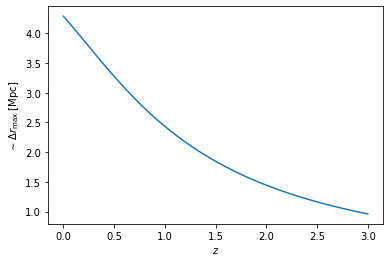

In [2]:
# Plot Delta r estimate based on z range
v_gal = 300 #km/s
z = np.linspace(0, 3)
H = 100 * 0.7 * cosmo.h_over_h0(1 / (1 + z)) #km/s/Mpc  # ccl works with scale factors
plt.plot(z, v_gal / H)
plt.xlabel('$z$')
plt.ylabel(r'$\sim \Delta r_{\rm max}$ [Mpc]')
plt.show()
plt.close()

# LRG

In [3]:
# Load catalog
cname = 'LRG'
cats[cname] = fitsio.read('../../../data/eBOSS_LRG_full_ALLdata-vDR16.fits')
# Clean it from galaxies with unknown redshift or z < 0
z = cats[cname]['Z']
cats[cname] =  cats[cname][~np.isnan(z) * z>=0]

# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 
train_sample[cname] = get_training_sample(cats[cname])  # The Cartesian coords of the galaxies

pairs[cname] = {}
pairs[cname]['mclosest'] = get_mutually_closest_nn(train_sample[cname], radius_cut)
pairs[cname]['isolated'] = get_isolated_pairs(train_sample[cname], radius_cut)
pairs[cname]['rel_isolated'] = get_relative_isolated_pairs(train_sample[cname], radius_cut)


iso_types = ['mclosest', 'isolated', 'rel_isolated']
for iso_type in iso_types:
    pairs[cname][iso_type]['cm'] = get_cm_coords(train_sample[cname], pairs[cname][iso_type]['ixs'])
    pairs[cname][iso_type]['vort'] = get_vort(cats[cname]['Z'],
                                              train_sample[cname],
                                              pairs[cname][iso_type]['ixs'],
                                              pairs[cname][iso_type]['dist'])

In [4]:
# Print column names
# cats['LRG'].dtype.names

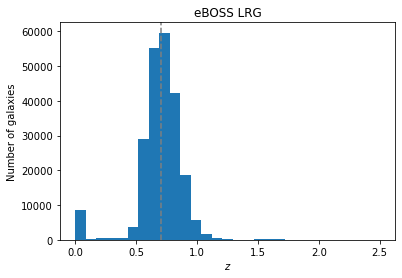

In [5]:
# Plot histogram of their redshifts and the mean redshift
z = cats[cname]['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 30));
plt.axvline(z_mean, ls='--', color='gray')
plt.xlabel(r'$z$')
plt.ylabel('Number of galaxies')
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

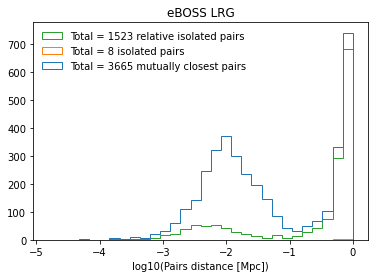

In [6]:
plt.hist([np.log10(pairs[cname]['mclosest']['dist']),
          np.log10(pairs[cname]['isolated']['dist']),
          np.log10(pairs[cname]['rel_isolated']['dist'])
         ],
         bins=30, histtype='step',
         label=[f"Total = {pairs[cname]['mclosest']['npairs']} mutually closest pairs",
                f"Total = {pairs[cname]['isolated']['npairs']} isolated pairs",
                f"Total = {pairs[cname]['rel_isolated']['npairs']} relative isolated pairs"])
plt.xlabel('log10(Pairs distance [Mpc])')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

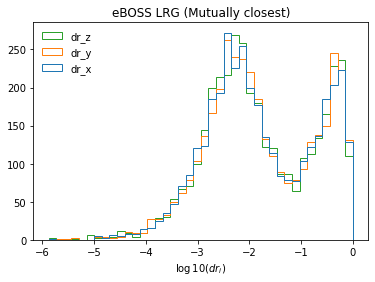

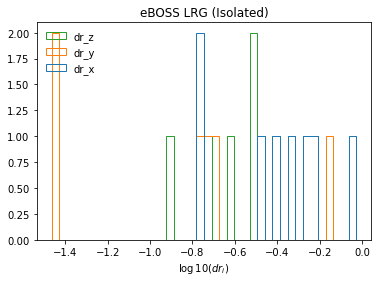

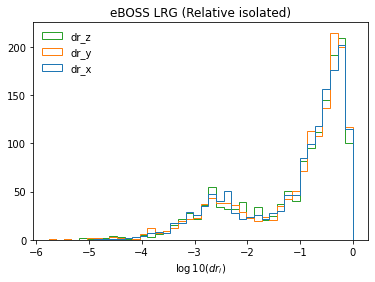

In [7]:
cname = 'LRG'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    pairs_ixs = pairs[cname][iso_type]['ixs']
    train_sample_diff = train_sample[cname][pairs_ixs[:, 0]] - train_sample[cname][pairs_ixs[:, 1]]

    plt.hist([np.log10(np.abs(li[li !=0])).tolist() for li in np.array(train_sample_diff).T], bins=40,
             histtype='step', label=['dr_x', 'dr_y', 'dr_z'])
    plt.xlabel('$\log10(dr_i)$')
    plt.legend(loc='upper left', frameon=False)
    plt.title(f'eBOSS {cname} ({label})')
    plt.show()
    plt.close()

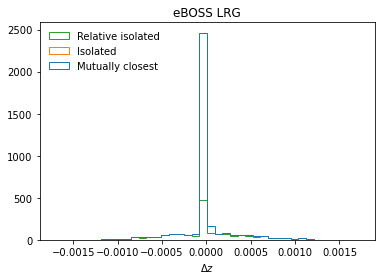

In [8]:
cname = 'LRG'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

dzs = []
for iso_type in iso_types:
    pairs_ixs = pairs[cname][iso_type]['ixs']
    dzs.append(cats[cname]['Z'][pairs_ixs[:, 0]] - cats[cname]['Z'][pairs_ixs[:, 1]])

plt.hist(dzs, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta z$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

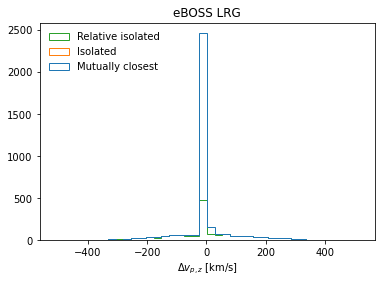

In [9]:
cname = 'LRG'
c = 3e5
cname = 'LRG'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

vels = []
for iso_type in iso_types:
    pairs_ixs = pairs[cname][iso_type]['ixs']
    vels.append(c * (cats[cname]['Z'][pairs_ixs[:, 0]] - cats[cname]['Z'][pairs_ixs[:, 1]]))

plt.hist(vels, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta v_{p,z}$ [km/s]')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

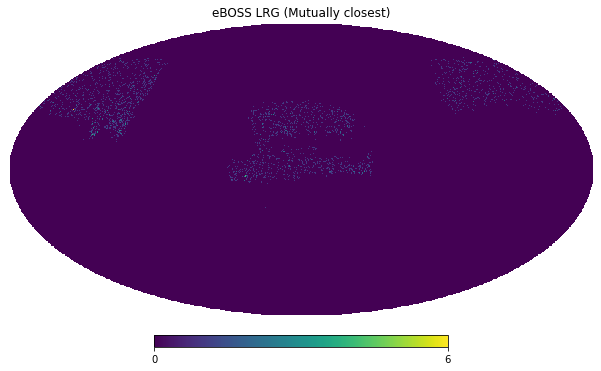

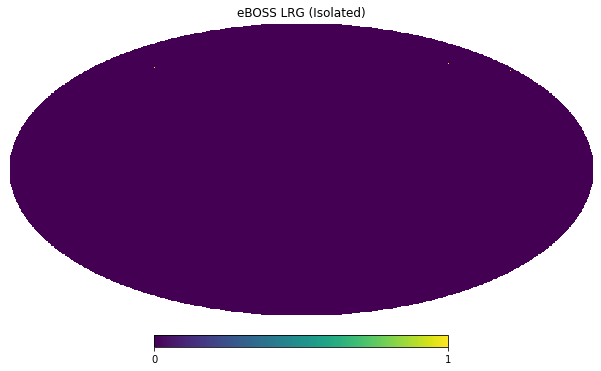

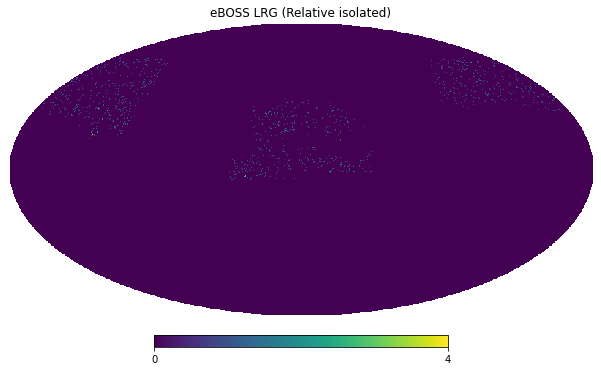

In [10]:
cname = 'LRG'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    cm = pairs[cname][iso_type]['cm']
    nc_map = get_number_counts_map(cm, nside)
    hp.mollview(nc_map, title=f'eBOSS {cname} ({label})')

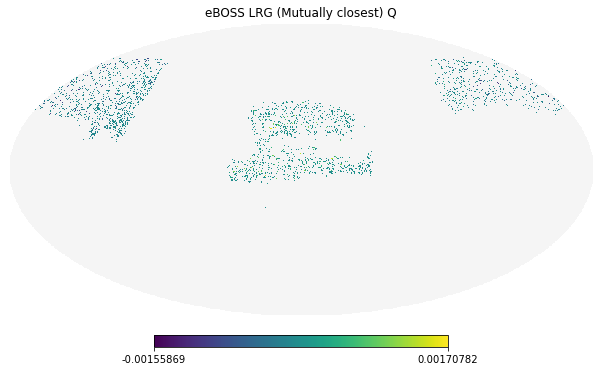

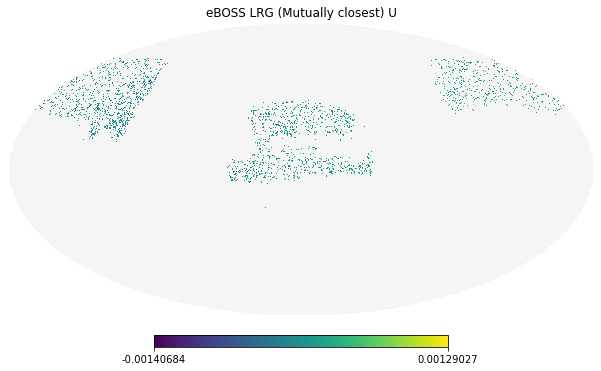

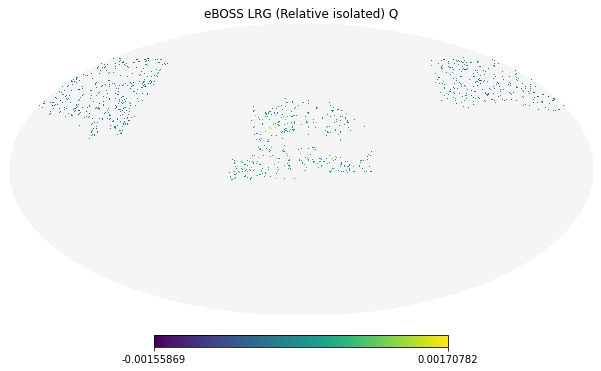

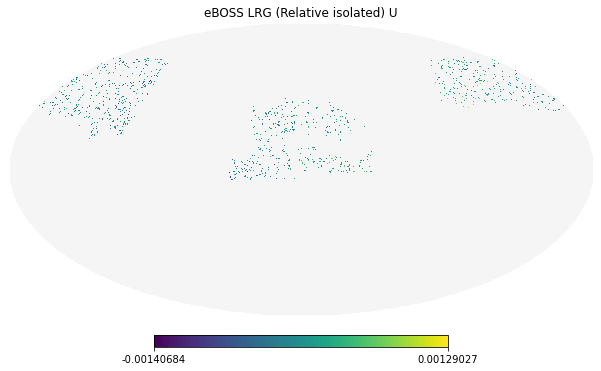

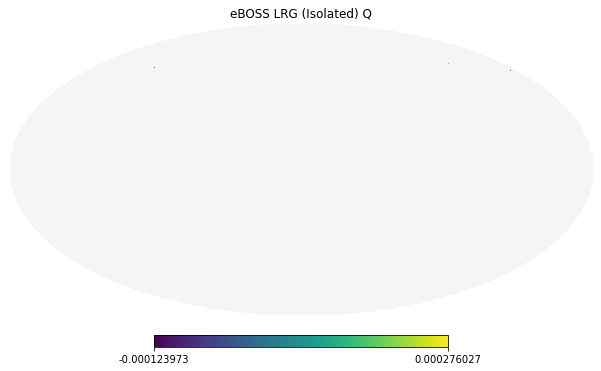

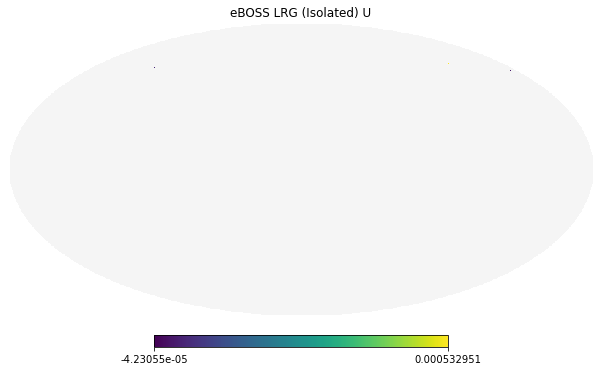

In [11]:
cname = 'LRG'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'rel_isolated', 'isolated']
labels = ['Mutually closest', 'Relative isolated', 'Isolated']

for iso_type, label in zip(iso_types, labels):
    cm = pairs[cname][iso_type]['cm']
    vort = pairs[cname][iso_type]['vort']
    vort_map, goodpix = get_vorticity_map(cm, vort, nside, return_goodpix=True)
    vort_map[:, ~goodpix] = hp.UNSEEN

    hp.mollview(vort_map[0], title=f'eBOSS {cname} ({label}) Q', badcolor='whitesmoke')
    hp.mollview(vort_map[1], title=f'eBOSS {cname} ({label}) U', badcolor='whitesmoke')

# CMASS

In [12]:
# Load catalog
cname = 'CMASS'
cat1 = fitsio.read('../../../data/galaxy_DR12v5_CMASS_North.fits.gz')
cat2 = fitsio.read('../../../data/galaxy_DR12v5_CMASS_South.fits.gz')
cats[cname] = np.concatenate([cat1, cat2])
# Clean it from galaxies with unknown redshift or z < 0
z = cats[cname]['Z']
cats[cname] =  cats[cname][~np.isnan(z) * z>=0] 

# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 
train_sample[cname] = get_training_sample(cats[cname])  # The Cartesian coords of the galaxies

pairs[cname] = {}
pairs[cname]['mclosest'] = get_mutually_closest_nn(train_sample[cname], radius_cut)
pairs[cname]['isolated'] = get_isolated_pairs(train_sample[cname], radius_cut)
pairs[cname]['rel_isolated'] = get_relative_isolated_pairs(train_sample[cname], radius_cut)

iso_types = ['mclosest', 'isolated', 'rel_isolated']
for iso_type in iso_types:
    pairs[cname][iso_type]['cm'] = get_cm_coords(train_sample[cname], pairs[cname][iso_type]['ixs'])
    pairs[cname][iso_type]['vort'] = get_vort(cats[cname]['Z'],
                                              train_sample[cname],
                                              pairs[cname][iso_type]['ixs'],
                                              pairs[cname][iso_type]['dist'])

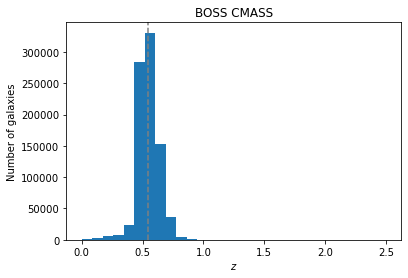

In [13]:
# Plot histogram of their redshifts and the mean redshift
z = cats[cname]['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 30));
plt.axvline(z_mean, ls='--', color='gray')
plt.xlabel(r'$z$')
plt.ylabel('Number of galaxies')
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

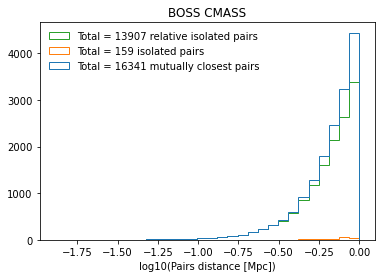

In [14]:
plt.hist([np.log10(pairs[cname]['mclosest']['dist']),
          np.log10(pairs[cname]['isolated']['dist']),
          np.log10(pairs[cname]['rel_isolated']['dist'])
         ],
         bins=30, histtype='step',
         label=[f"Total = {pairs[cname]['mclosest']['npairs']} mutually closest pairs",
                f"Total = {pairs[cname]['isolated']['npairs']} isolated pairs",
                f"Total = {pairs[cname]['rel_isolated']['npairs']} relative isolated pairs"])
plt.xlabel('log10(Pairs distance [Mpc])')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

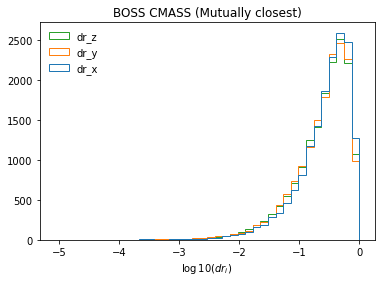

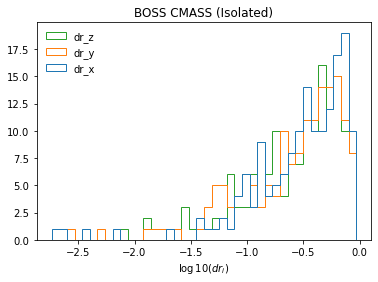

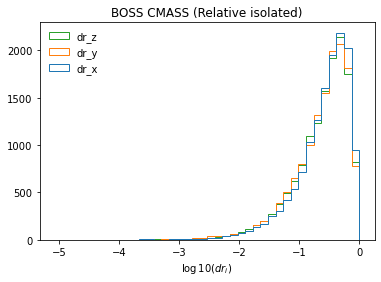

In [15]:
cname = 'CMASS'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    pairs_ixs = pairs[cname][iso_type]['ixs']
    train_sample_diff = train_sample[cname][pairs_ixs[:, 0]] - train_sample[cname][pairs_ixs[:, 1]]

    plt.hist([np.log10(np.abs(li[li !=0])).tolist() for li in np.array(train_sample_diff).T], bins=40,
             histtype='step', label=['dr_x', 'dr_y', 'dr_z'])
    plt.xlabel('$\log10(dr_i)$')
    plt.legend(loc='upper left', frameon=False)
    plt.title(f'BOSS {cname} ({label})')
    plt.show()
    plt.close()

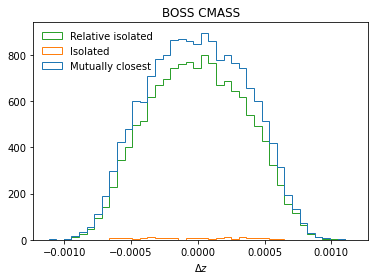

In [16]:
cname = 'CMASS'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

dzs = []
for iso_type in iso_types:
    pairs_ixs = pairs[cname][iso_type]['ixs']
    dzs.append(cats[cname]['Z'][pairs_ixs[:, 0]] - cats[cname]['Z'][pairs_ixs[:, 1]])

plt.hist(dzs, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta z$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

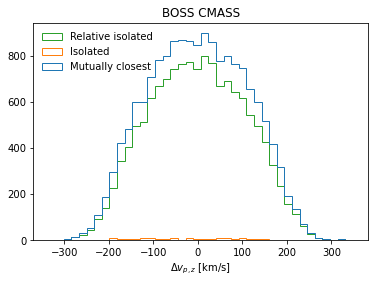

In [17]:
cname = 'CMASS'
c = 3e5

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

vels = []
for iso_type in iso_types:
    pairs_ixs = pairs[cname][iso_type]['ixs']
    vels.append(c * (cats[cname]['Z'][pairs_ixs[:, 0]] - cats[cname]['Z'][pairs_ixs[:, 1]]))

plt.hist(vels, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta v_{p,z}$ [km/s]')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

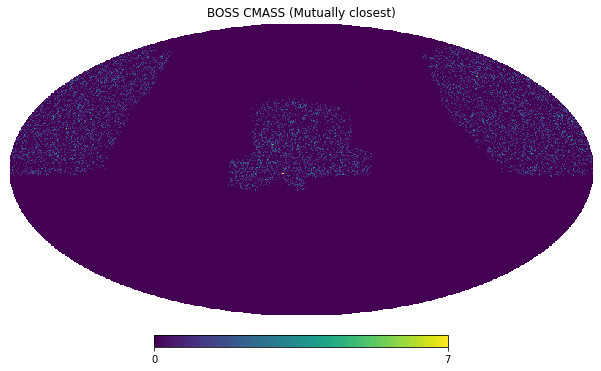

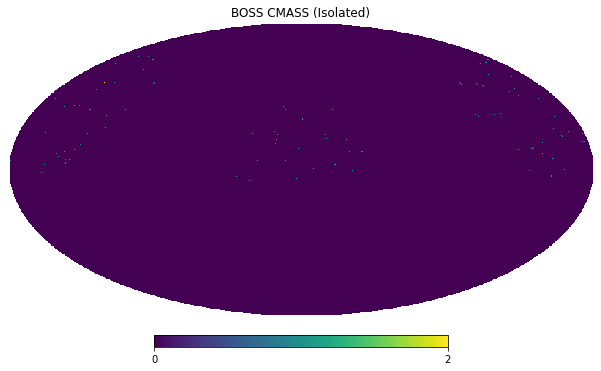

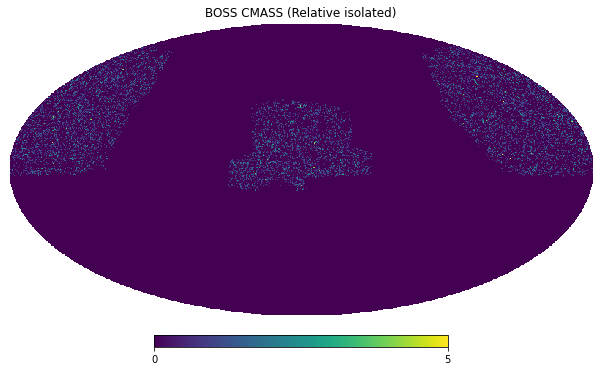

In [18]:
cname = 'CMASS'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    cm = pairs[cname][iso_type]['cm']
    nc_map = get_number_counts_map(cm, nside)
    hp.mollview(nc_map, title=f'BOSS {cname} ({label})')

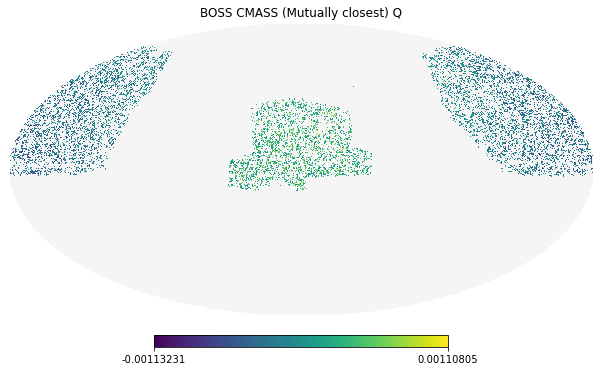

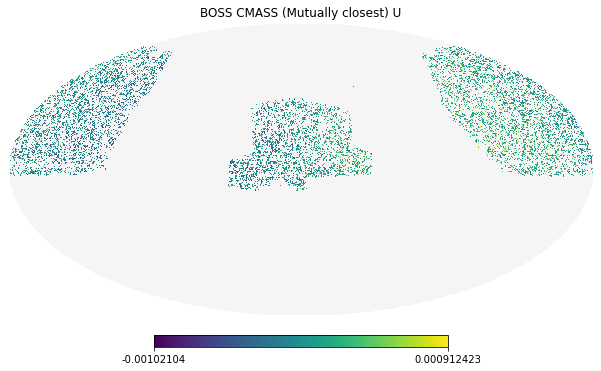

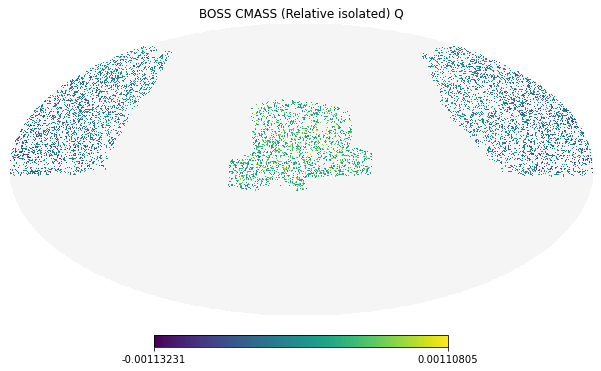

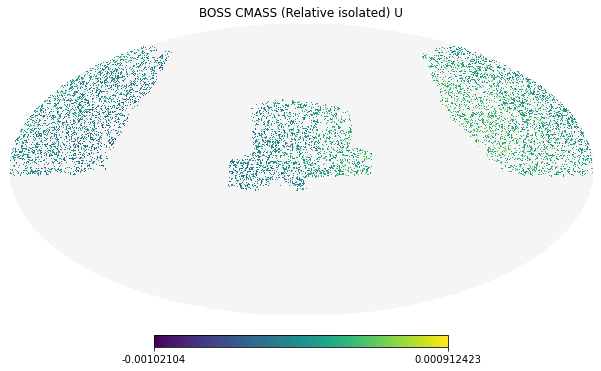

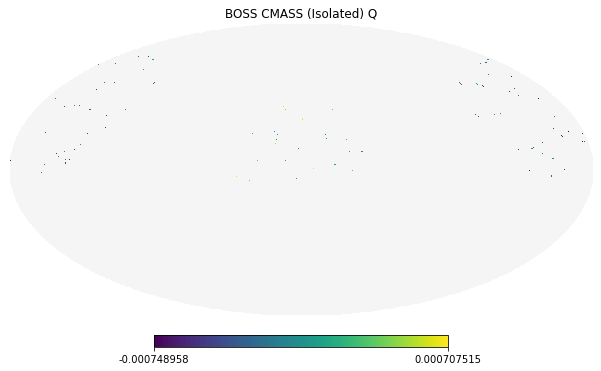

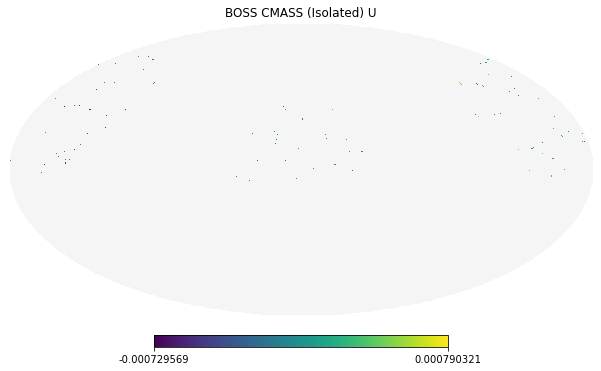

In [19]:
cname = 'CMASS'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'rel_isolated', 'isolated']
labels = ['Mutually closest', 'Relative isolated', 'Isolated']

for iso_type, label in zip(iso_types, labels):
    cm = pairs[cname][iso_type]['cm']
    vort = pairs[cname][iso_type]['vort']
    vort_map, goodpix = get_vorticity_map(cm, vort, nside, return_goodpix=True)
    vort_map[:, ~goodpix] = hp.UNSEEN

    hp.mollview(vort_map[0], title=f'BOSS {cname} ({label}) Q', badcolor='whitesmoke')
    hp.mollview(vort_map[1], title=f'BOSS {cname} ({label}) U', badcolor='whitesmoke')

# LOWZ

In [20]:
# Load catalog
cname = 'LOWZ'
cats[cname] = fitsio.read('../../../data/galaxy_DR12v5_LOWZ_South.fits.gz')

# Clean it from galaxies with unknown redshift or z < 0
z = cats[cname]['Z']
cats[cname] =  cats[cname][~np.isnan(z) * z>=0] 

# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 
train_sample[cname] = get_training_sample(cats[cname])  # The Cartesian coords of the galaxies

pairs[cname] = {}
pairs[cname]['mclosest'] = get_mutually_closest_nn(train_sample[cname], radius_cut)
pairs[cname]['isolated'] = get_isolated_pairs(train_sample[cname], radius_cut)
pairs[cname]['rel_isolated'] = get_relative_isolated_pairs(train_sample[cname], radius_cut)

iso_types = ['mclosest', 'isolated', 'rel_isolated']
for iso_type in iso_types:
    pairs[cname][iso_type]['cm'] = get_cm_coords(train_sample[cname], pairs[cname][iso_type]['ixs'])
    pairs[cname][iso_type]['vort'] = get_vort(cats[cname]['Z'],
                                              train_sample[cname],
                                              pairs[cname][iso_type]['ixs'],
                                              pairs[cname][iso_type]['dist'])

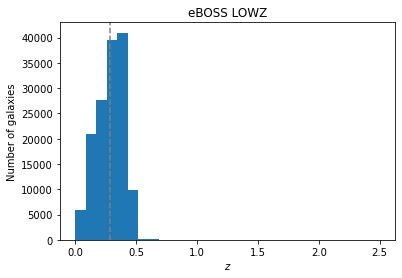

In [21]:
# Plot histogram of their redshifts and the mean redshift
z = cats[cname]['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 30));
plt.axvline(z_mean, ls='--', color='gray')
plt.xlabel(r'$z$')
plt.ylabel('Number of galaxies')
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

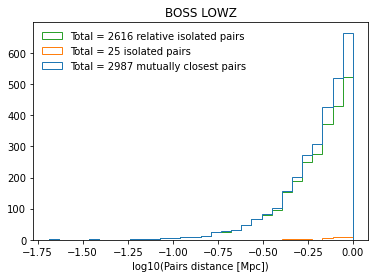

In [22]:
plt.hist([np.log10(pairs[cname]['mclosest']['dist']),
          np.log10(pairs[cname]['isolated']['dist']),
          np.log10(pairs[cname]['rel_isolated']['dist'])
         ],
         bins=30, histtype='step',
         label=[f"Total = {pairs[cname]['mclosest']['npairs']} mutually closest pairs",
                f"Total = {pairs[cname]['isolated']['npairs']} isolated pairs",
                f"Total = {pairs[cname]['rel_isolated']['npairs']} relative isolated pairs"])
plt.xlabel('log10(Pairs distance [Mpc])')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

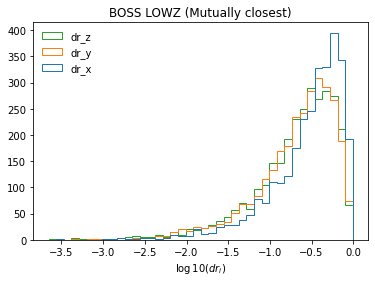

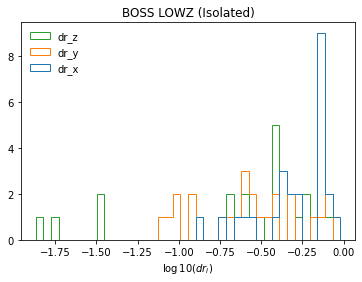

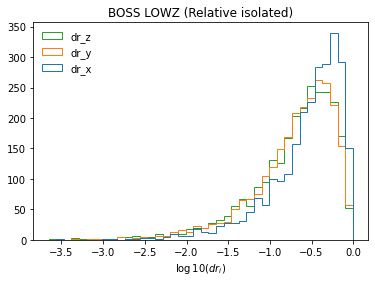

In [23]:
cname = 'LOWZ'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    pairs_ixs = pairs[cname][iso_type]['ixs']
    train_sample_diff = train_sample[cname][pairs_ixs[:, 0]] - train_sample[cname][pairs_ixs[:, 1]]

    plt.hist([np.log10(np.abs(li[li !=0])).tolist() for li in np.array(train_sample_diff).T], bins=40,
             histtype='step', label=['dr_x', 'dr_y', 'dr_z'])
    plt.xlabel('$\log10(dr_i)$')
    plt.legend(loc='upper left', frameon=False)
    plt.title(f'BOSS {cname} ({label})')
    plt.show()
    plt.close()

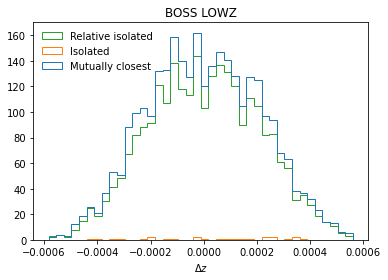

In [24]:
cname = 'LOWZ'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

dzs = []
for iso_type in iso_types:
    pairs_ixs = pairs[cname][iso_type]['ixs']
    dzs.append(cats[cname]['Z'][pairs_ixs[:, 0]] - cats[cname]['Z'][pairs_ixs[:, 1]])

plt.hist(dzs, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta z$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

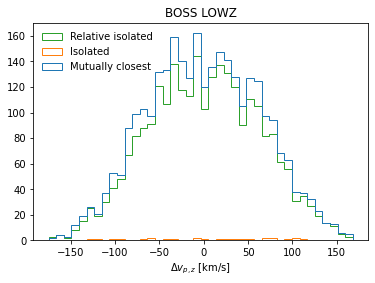

In [25]:
cname = 'LOWZ'
c = 3e5

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

vels = []
for iso_type in iso_types:
    pairs_ixs = pairs[cname][iso_type]['ixs']
    vels.append(c * (cats[cname]['Z'][pairs_ixs[:, 0]] - cats[cname]['Z'][pairs_ixs[:, 1]]))

plt.hist(vels, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta v_{p,z}$ [km/s]')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

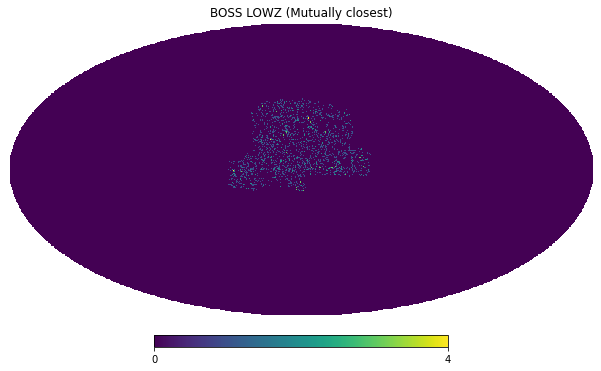

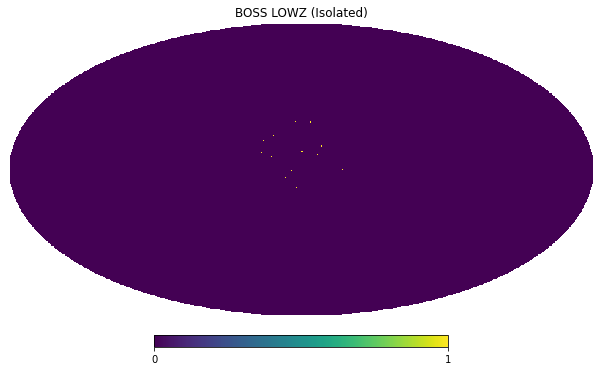

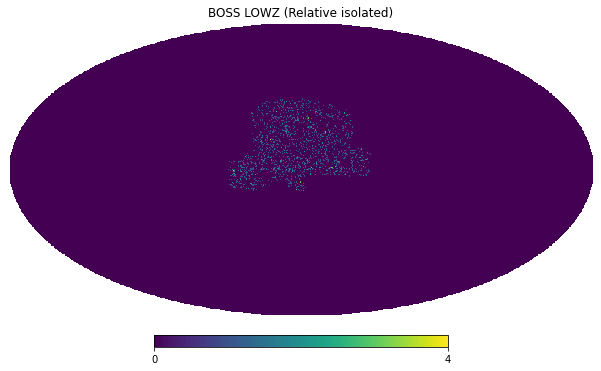

In [26]:
cname = 'LOWZ'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    cm = pairs[cname][iso_type]['cm']
    nc_map = get_number_counts_map(cm, nside)
    hp.mollview(nc_map, title=f'BOSS {cname} ({label})')

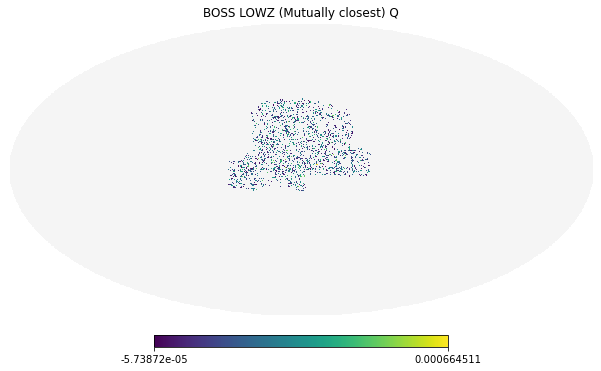

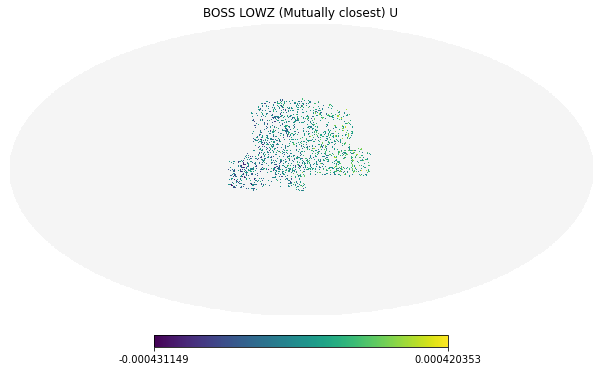

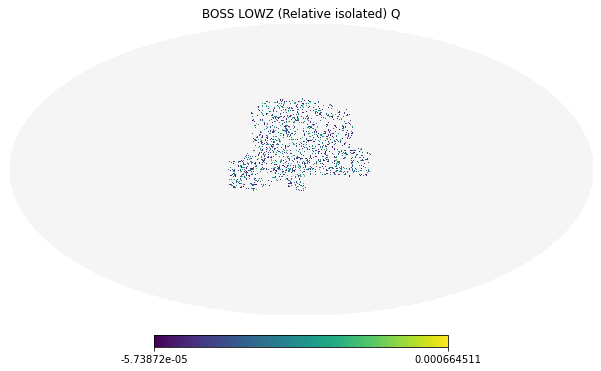

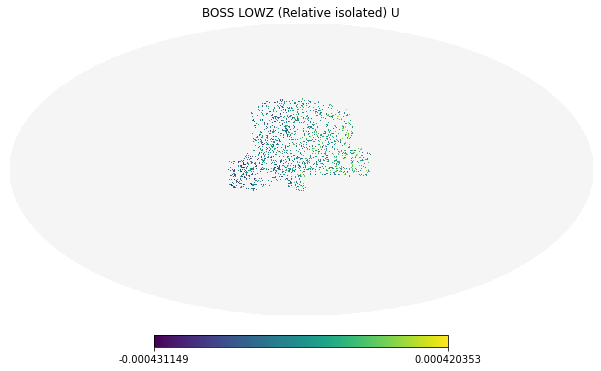

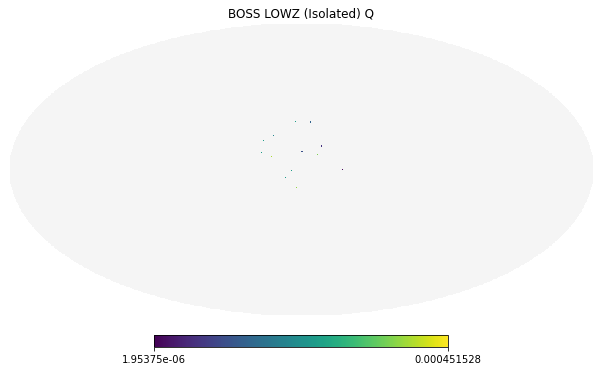

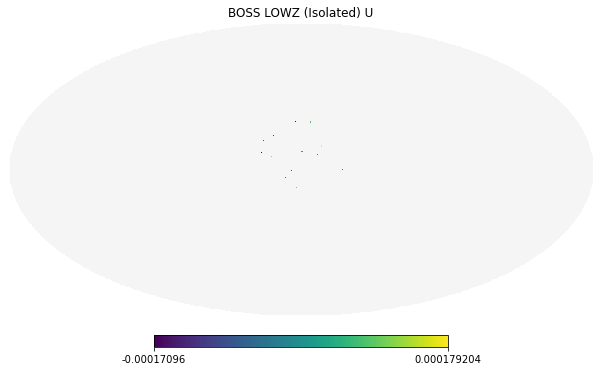

In [27]:
cname = 'LOWZ'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'rel_isolated', 'isolated']
labels = ['Mutually closest', 'Relative isolated', 'Isolated']

for iso_type, label in zip(iso_types, labels):
    cm = pairs[cname][iso_type]['cm']
    vort = pairs[cname][iso_type]['vort']
    vort_map, goodpix = get_vorticity_map(cm, vort, nside, return_goodpix=True)
    vort_map[:, ~goodpix] = hp.UNSEEN

    hp.mollview(vort_map[0], title=f'BOSS {cname} ({label}) Q', badcolor='whitesmoke')
    hp.mollview(vort_map[1], title=f'BOSS {cname} ({label}) U', badcolor='whitesmoke')